<a href="https://colab.research.google.com/github/wksmirnowa/machinelearning_homeworks/blob/master/HW08_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Реккурентные нейронные сети

In [52]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, LSTM, GRU, Bidirectional, TimeDistributed, InputLayer, Embedding, Conv1D, Flatten, Concatenate, Input, concatenate
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model

import numpy as np
from itertools import chain
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from collections import Counter
import nltk
nltk.download('punkt')
nltk.download('treebank')
from string import punctuation, ascii_lowercase
punct = punctuation+'«»—…“”*№–'

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Package treebank is already up-to-date!


In [0]:
from numpy.random import seed
seed(0)
from tensorflow.random import set_seed
set_seed(0)

In [0]:
def model_picture(model):
  print(model.history.history.keys())
  plt.plot(model.history.history['accuracy'])
  plt.plot(model.history.history['val_accuracy'])
  plt.title('model categorical_crossentropy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

In [0]:
tagged_sentences = nltk.corpus.treebank.tagged_sents()

In [0]:
tagged_sentences[0]

[('Pierre', 'NNP'),
 ('Vinken', 'NNP'),
 (',', ','),
 ('61', 'CD'),
 ('years', 'NNS'),
 ('old', 'JJ'),
 (',', ','),
 ('will', 'MD'),
 ('join', 'VB'),
 ('the', 'DT'),
 ('board', 'NN'),
 ('as', 'IN'),
 ('a', 'DT'),
 ('nonexecutive', 'JJ'),
 ('director', 'NN'),
 ('Nov.', 'NNP'),
 ('29', 'CD'),
 ('.', '.')]

In [0]:
sentences, sentence_tags =[], [] 
for tagged_sentence in tagged_sentences:
    sentence, tags = zip(*tagged_sentence)
    sentences.append(sentence)
    sentence_tags.append(tags)

In [0]:
sentences[0]

('Pierre',
 'Vinken',
 ',',
 '61',
 'years',
 'old',
 ',',
 'will',
 'join',
 'the',
 'board',
 'as',
 'a',
 'nonexecutive',
 'director',
 'Nov.',
 '29',
 '.')

In [0]:
len(sentence_tags)

3914

In [0]:
sent_train, sent_test, tag_train, tag_test = train_test_split(sentences, sentence_tags, test_size=0.2, random_state=0)

In [0]:
vocab = Counter()
for sent in sent_train:
    sent = [word.lower() for word in sent]
    vocab.update(sent)

In [0]:
filtered_vocab = {word for word in vocab if vocab[word] > 5}

In [0]:
len(filtered_vocab)

1679

In [0]:
word2id = {'PAD':0,'UNK':1}    
for i,word in enumerate(filtered_vocab):
      word2id[word] = i + 2

id2word = {i:word for word, i in word2id.items()}

In [0]:
len(id2word)

1681

In [0]:
tag2id = {'PAD':0}  
for tags in tag_train:
    for tag in tags:
      if tag.lower() not in tag2id:
        tag2id[tag.lower()] = len(tag2id)

id2tag = {i:tag for tag, i in tag2id.items()}

In [0]:
len(id2tag)

47

In [0]:
def sym_tokenize(text):
  text = text.lower()
  spaces = '\t\n\r\x0b\x0c' #из символов модуля string
  result = []

  for sym in text:
    if sym in spaces or sym == ' ':
      result.append(' ')
    elif sym in ascii_lowercase:
      result.append(sym)
    elif sym in digits:
      result.append(sym)
    elif sym in punct:
      result.append(sym)
    else:
      result.append(sym)
  return result

In [0]:
def make_vocab(texts):
  vocab = Counter()

  for tup in texts:
    for text in tup:
      vocab.update(sym_tokenize(text))

  filtered_vocab = set()

  for sym in vocab:
    if vocab[sym] > 1:
        filtered_vocab.add(sym)
        
  return filtered_vocab

In [0]:
filtered_sym_vocab = make_vocab(sent_train)

In [14]:
len(filtered_sym_vocab)

52

In [0]:
sym2id = {'UNK':1, 'PAD':0}
for sym in filtered_sym_vocab:
  if sym not in sym2id.keys():
    sym2id[sym] = len(sym2id)

In [0]:
id2sym = {i:sym for sym, i in sym2id.items()}

In [0]:
len(id2sym)

54

In [0]:
def data2ints(data, smth2id):
  int_data = []
  for seq in data:
      int_seq = []
      for i in seq:
          try:
            int_seq.append(smth2id[i.lower()])
          except KeyError:
            int_seq.append(smth2id['UNK'])
  
      int_data.append(int_seq)
  return int_data
 

## Модель

In [0]:
# зафиксируем размер
max_seq_len = min(max(len(x) for x in sent_train), 100)
max_char_len = [[len(word) for word in sent] for sent in sent_train]
max_char_len = max(chain(*max_char_len)) #сделаем максимальное для каждого элемента в max_char_len
max_char_len = min(max_char_len, 16) #ограничим максимальные значения – до 16

In [0]:
X_train_ids, X_test_ids = data2ints(sent_train, word2id), data2ints(sent_test, word2id)
y_train_ids, y_test_ids = data2ints(tag_train, tag2id), data2ints(tag_test, tag2id)

X_train_ids_sym = [[[sym2id.get(sym.lower(), 1) for sym in word] for word in sent] for sent in sent_train]
X_test_ids_sym = [[[sym2id.get(sym.lower(), 1) for sym in word] for word in sent] for sent in sent_test]

X_train, X_test = pad_sequences(X_train_ids, maxlen=max_seq_len, padding='post'), pad_sequences(X_test_ids, maxlen=max_seq_len, padding='post')
y_train_pad, y_test_pad = pad_sequences(y_train_ids, maxlen=max_seq_len, padding='post', truncating='post'), pad_sequences(y_test_ids, maxlen=max_seq_len, padding='post', truncating='post')

X_train_sym = pad_sequences([pad_sequences(ids, maxlen=max_char_len, padding='post') for ids in X_train_ids_sym], maxlen=max_seq_len, padding='post')
X_test_sym = pad_sequences([pad_sequences(ids, maxlen=max_char_len, padding='post') for ids in X_test_ids_sym], maxlen=max_seq_len, padding='post')

In [0]:
y_train, y_test = to_categorical(y_train_pad, num_classes=len(tag2id)), to_categorical(y_test_pad, num_classes=len(tag2id))

In [0]:
sentences_input = Input(shape=(max_seq_len,))
symbols_input = Input(shape=(max_seq_len, max_char_len))

embedding_sents = Embedding(len(word2id), 65, mask_zero=True)(sentences_input)
embedding_symbols = TimeDistributed(Embedding(len(sym2id), 8, input_length=max_char_len, mask_zero=False))(symbols_input)

bilstm_sentences = Bidirectional(LSTM(256, return_sequences=True))(embedding_sents)
drop1 = Dropout(0.2)(bilstm_sentences)
conv = TimeDistributed(Conv1D(128, 3, 1, padding='same'))(embedding_symbols)
flat = TimeDistributed(Flatten())(conv)
drop2 = Dropout(0.2)(flat)
drops = concatenate([drop1, drop2])

bilstm = Bidirectional(LSTM(256, return_sequences=True))(drops)
dense = TimeDistributed(Dense(len(tag2id)*2, activation='selu'))(bilstm)
drop = Dropout(0.2)(dense)

output = TimeDistributed(Dense(len(tag2id), activation='softmax'))(drop)
model = Model(inputs=[sentences_input, symbols_input], outputs=output)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

checkpoint = tf.keras.callbacks.ModelCheckpoint('model.weights', 
                                                monitor='val_accuracy', 
                                                verbose=1, 
                                                save_weights_only=True, 
                                                save_best_only=True, 
                                                mode='max', 
                                                save_freq='epoch' 
                                               )
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                              min_delta=0.01, 
                                              patience=5, 
                                              verbose=1, 
                                              mode='max',
                                              )
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [41]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 100, 16)]    0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
time_distributed_20 (TimeDistri (None, 100, 16, 8)   432         input_10[0][0]                   
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 100, 65)      109265      input_9[0][0]                    
____________________________________________________________________________________________

In [42]:
%%time
model.fit(x=[X_train,X_train_sym], y=y_train, 
          validation_data=([X_test, X_test_sym], y_test),
          batch_size=120,
         epochs=20,
        callbacks=[checkpoint, early_stop])

Epoch 1/20
27/27 [==============================] - ETA: 0s - loss: 0.8024 - accuracy: 0.0645 
Epoch 00001: val_accuracy improved from -inf to 0.05824, saving model to model.weights
27/27 [==============================] - 374s 14s/step - loss: 0.8024 - accuracy: 0.0645 - val_loss: 0.7319 - val_accuracy: 0.0582
Epoch 2/20
27/27 [==============================] - ETA: 0s - loss: 0.5951 - accuracy: 0.0914 
Epoch 00002: val_accuracy improved from 0.05824 to 0.14335, saving model to model.weights
27/27 [==============================] - 368s 14s/step - loss: 0.5951 - accuracy: 0.0914 - val_loss: 0.4175 - val_accuracy: 0.1433
Epoch 3/20
27/27 [==============================] - ETA: 0s - loss: 0.3100 - accuracy: 0.1642 
Epoch 00003: val_accuracy improved from 0.14335 to 0.20057, saving model to model.weights
27/27 [==============================] - 371s 14s/step - loss: 0.3100 - accuracy: 0.1642 - val_loss: 0.2209 - val_accuracy: 0.2006
Epoch 4/20
27/27 [==============================] - ETA

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


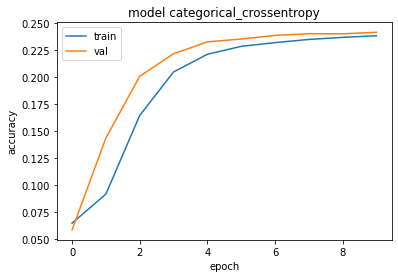

In [43]:
model_picture(model)

## Проверка работы

In [0]:
def tokenize(text):
    
    words = [word.strip(punct) for word in text.lower().split() if word]
    words = [word for word in words if word]

    return words

def check_morph_tagging(text: str, model=model_1):
    
    tokenized_text = tokenize(text)

    symbols = [[sym2id.get(sym.lower(), 1) for sym in word] for word in tokenized_text]
    pad_symbols = pad_sequences([pad_sequences(ids, maxlen=max_char_len, padding='post') for ids in [symbols]], maxlen=max_seq_len, padding='post')
    sentence = [word2id.get(word.lower(), 1) for word in tokenized_text]
    pad_sentence = pad_sequences([sentence], maxlen=max_seq_len, padding='post')

    predicted_tags = model.predict([pad_sentence, pad_symbols])
    predicted_tags = [id2tag[tag] for tag in np.argmax(predicted_tags, axis=2)[0, :len(tokenized_text)]]

    return list(zip(tokenized_text, predicted_tags))

In [112]:
check_morph_tagging('There is no one thing that will fix this virus, it is layer upon layer, upon layer.')

[('there', 'ex'),
 ('is', 'vbz'),
 ('no', 'dt'),
 ('one', 'cd'),
 ('thing', 'nn'),
 ('that', 'in'),
 ('will', 'md'),
 ('fix', 'vb'),
 ('this', 'dt'),
 ('virus', 'nn'),
 ('it', 'prp'),
 ('is', 'vbz'),
 ('layer', 'jj'),
 ('upon', 'jj'),
 ('layer', 'nn'),
 ('upon', 'in'),
 ('layer', 'nn')]

In [116]:
check_morph_tagging('The Courier wonders whether, in light of warnings that Scotland\'s economy might not return to pre-coronavirus levels until 2023, the first minister expects Scotland to be an independent country by then.')

[('the', 'dt'),
 ('courier', 'nn'),
 ('wonders', 'vbz'),
 ('whether', 'in'),
 ('in', 'in'),
 ('light', 'nn'),
 ('of', 'in'),
 ('warnings', 'nns'),
 ('that', 'in'),
 ("scotland's", 'rb'),
 ('economy', 'nn'),
 ('might', 'md'),
 ('not', 'rb'),
 ('return', 'vb'),
 ('to', 'to'),
 ('pre-coronavirus', 'jj'),
 ('levels', 'nns'),
 ('until', 'in'),
 ('2023', 'cd'),
 ('the', 'dt'),
 ('first', 'jj'),
 ('minister', 'nn'),
 ('expects', 'vbz'),
 ('scotland', 'vbd'),
 ('to', 'to'),
 ('be', 'vb'),
 ('an', 'dt'),
 ('independent', 'jj'),
 ('country', 'nn'),
 ('by', 'in'),
 ('then', 'rb')]